In [1]:
%matplotlib inline


BIDS dataset first and second level analysis
============================================

Author : Martin Perez-Guevara: 2016



Full step-by-step example of fitting a GLM to perform a first and second level
analysis in a BIDS dataset and visualizing the results. Details about the BIDS
standard can be consulted at http://bids.neuroimaging.io/

More specifically:

1. Download an fMRI BIDS dataset with two language conditions to contrast.
2. Extract automatically from the BIDS dataset first level model objects
3. Fit a second level model on the fitted first level models. Notice that
   in this case the preprocessed bold images were already normalized to the
   same MNI space.



To run this example, you must launch IPython via ``ipython
--matplotlib`` in a terminal, or use the Jupyter notebook.
    :depth: 1



Fetch example BIDS dataset
--------------------------
We download an simplified BIDS dataset made available for illustrative
purposes. It contains only the necessary
information to run a statistical analysis using Nistats. The raw data
subject folders only contain bold.json and events.tsv files, while the
derivatives folder with preprocessed files contain preproc.nii and
confounds.tsv files.



In [4]:
!pip install botocore

    100% |████████████████████████████████| 5.3MB 2.9MB/s eta 0:00:01


In [5]:
from nistats.datasets import fetch_bids_langloc_dataset
data_dir, _ = fetch_bids_langloc_dataset()

Obtain automatically FirstLevelModel objects and fit arguments
--------------------------------------------------------------
From the dataset directory we obtain automatically FirstLevelModel objects
with their subject_id filled from the BIDS dataset. Moreover we obtain
for each model a dictionary with run_imgs, events and confounder regressors
since in this case a confounds.tsv file is available in the BIDS dataset.
To get the first level models we only have to specify the dataset directory
and the task_label as specified in the file names.



In [6]:
from nistats.first_level_model import first_level_models_from_bids
task_label = 'languagelocalizer'
space_label = 'MNI152nonlin2009aAsym'
models, models_run_imgs, models_events, models_confounds = \
    first_level_models_from_bids(
        data_dir, task_label, space_label,
        img_filters=[('variant', 'smoothResamp')])

/Users/Ralf/.local/lib/python3.6/site-packages/nistats-0.0.1a0-py3.6.egg/nistats/first_level_model.py:678: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/Ralf/nilearn_data/bids_langloc_example/bids_langloc_dataset/sub-01/ses-02/func/sub-01_ses-02_task-languagelocalizer_bold.json' mode='r' encoding='UTF-8'>
  specs = json.load(open(img_specs[0], 'r'))
/Users/Ralf/.local/lib/python3.6/site-packages/nistats-0.0.1a0-py3.6.egg/nistats/first_level_model.py:693: UserWarning: SliceTimingRef not found in file /Users/Ralf/nilearn_data/bids_langloc_example/bids_langloc_dataset/sub-01/ses-02/func/sub-01_ses-02_task-languagelocalizer_bold.json. It will be assumed that the slice timing reference is 0.0 percent of the repetition time. If it is not the case it will need to be set manually in the generated list of models
  img_specs[0])


Quick sanity check on fit arguments
-----------------------------------
Additional checks or information extraction from pre-processed data can
be made here



We just expect one run img per subject.



In [7]:
import os
print([os.path.basename(run) for run in models_run_imgs[0]])

['sub-01_ses-02_task-languagelocalizer_bold_space-MNI152nonlin2009aAsym_variant-smoothResamp_preproc.nii.gz']


The only confounds stored are regressors obtained from motion correction. As
we can verify from the column headers of the confounds table corresponding
to the only run_img present



In [8]:
print(models_confounds[0][0].columns)

Index(['RotX', 'RotY', 'RotZ', 'X', 'Y', 'Z'], dtype='object')


During this acquisition the subject read blocks of sentences and
consonant strings. So these are our only two conditions in events.
We verify there are 12 blocks for each condition.



In [9]:
print(models_events[0][0]['trial_type'].value_counts())

string      12
language    12
Name: trial_type, dtype: int64


First level model estimation
----------------------------
Now we simply fit each first level model and plot for each subject the
contrast that reveals the language network (language - string). Notice that
we can define a contrast using the names of the conditions especified in the
events dataframe. Sum, substraction and scalar multiplication are allowed.



/Users/Ralf/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/Users/Ralf/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/Ralf/anaconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/Users/Ralf/.local/lib/python3.6/site-packages/nistats-0.0.1a0-py3.6.egg/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  frame_times.max() * (1 + 1. / (n - 1)), n_hr)
/Users/Ralf/.local/lib/pytho

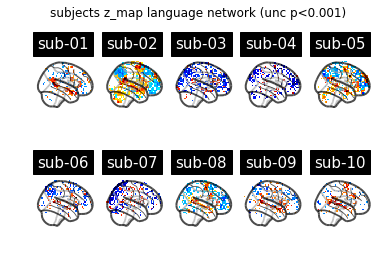

In [10]:
from nilearn import plotting
import matplotlib.pyplot as plt
from scipy.stats import norm

fig, axes = plt.subplots(nrows=2, ncols=5)
model_and_args = zip(models, models_run_imgs, models_events, models_confounds)
for midx, (model, imgs, events, confounds) in enumerate(model_and_args):
    model.fit(imgs, events, confounds)
    zmap = model.compute_contrast('language-string')
    plotting.plot_glass_brain(zmap, colorbar=False, threshold=norm.isf(0.001),
                              title=('sub-' + model.subject_label),
                              axes=axes[int(midx / 5), int(midx % 5)],
                              plot_abs=False, display_mode='x')
fig.suptitle('subjects z_map language network (unc p<0.001)')
plt.show()

Second level model estimation
-----------------------------
We just have to provide the list of fitted FirstLevelModel objects
to the SecondLevelModel object for estimation. We can do this because
all subjects share a similar design matrix (same variables reflected in
column names)



In [10]:
from nistats.second_level_model import SecondLevelModel
second_level_input = models
second_level_model = SecondLevelModel(smoothing_fwhm=8.0)
second_level_model = second_level_model.fit(second_level_input)

Computing contrasts at the second level is as simple as at the first level
Since we are not providing confounders we are performing an one-sample test
at the second level with the images determined by the specified first level
contrast.



In [11]:
zmap = second_level_model.compute_contrast(first_level_contrast='language-string')

The group level contrast reveals a left lateralized fronto-temporal
language network



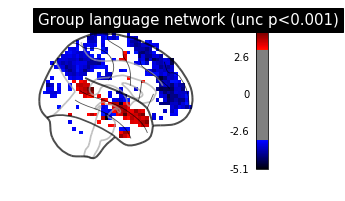

In [12]:
plotting.plot_glass_brain(zmap, colorbar=True, threshold=norm.isf(0.001),
                          title='Group language network (unc p<0.001)',
                          plot_abs=False, display_mode='x')
plotting.show()